In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [3]:
data = pd.read_csv('../../Data/20x43_DEFG1060.csv')
data.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,mths_since_last_delinq,acc_now_delinq,collections_12_mths_ex_med,pub_rec,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified,loan_status_bin
0,1.411209,-0.188121,0.398143,-0.968551,-0.968551,-0.162888,1.437204,0.413296,1.482470,-0.314595,2.024852,-0.444988,1.831332,-0.080884,-0.149023,1.008324,-0.901469,-0.231921,1.411582,1.401707,0.924098,0.998387,-0.030931,-0.915786,-0.349702,1.142106,-0.122229,3.950487,-0.785813,-0.292010,-0.144506,-0.189319,-0.213967,-0.212005,-0.548857,-0.063488,-0.228236,-0.177055,-0.086669,-0.561233,1.238213,-0.75931,1.0
1,-0.680389,-0.058914,-1.184157,1.916545,1.916545,-0.579187,-0.677878,-0.605451,-1.068222,-0.696583,1.255252,0.420662,-0.278130,-0.080884,-0.149023,-0.414920,-0.972717,-0.231921,1.411582,0.013271,0.598886,-0.591192,-0.030931,-0.915786,-0.349702,1.142106,-0.122229,-0.253133,-0.785813,3.424543,-0.144506,-0.189319,-0.213967,-0.212005,-0.548857,-0.063488,-0.228236,-0.177055,-0.086669,-0.561233,1.238213,-0.75931,0.0
2,-0.945820,-0.287511,-0.294533,0.080575,0.080575,0.605333,-0.888756,-0.945033,-1.145516,-0.607503,0.485653,-0.444988,-0.861599,-0.080884,-0.149023,-0.414920,0.190995,-0.231921,1.411582,1.401707,1.574522,-1.650911,-0.030931,1.091958,-0.349702,-0.875576,-0.122229,-0.253133,1.272568,-0.292010,-0.144506,-0.189319,-0.213967,-0.212005,-0.548857,-0.063488,-0.228236,-0.177055,-0.086669,-0.561233,1.238213,-0.75931,0.0
3,0.147756,-0.039036,0.075864,-0.706270,-0.706270,-0.579187,0.140296,-0.096078,0.554946,-0.321490,2.794451,3.017612,-0.861599,-0.080884,-0.149023,1.008324,-0.462109,-0.231921,1.411582,0.013271,0.598886,-0.591192,-0.030931,1.091958,-0.349702,-0.875576,-0.122229,-0.253133,-0.785813,-0.292010,-0.144506,-0.189319,-0.213967,-0.212005,-0.548857,-0.063488,4.381428,-0.177055,-0.086669,-0.561233,1.238213,-0.75931,1.0
4,1.496147,-0.267633,0.527950,4.014796,4.014796,-0.579187,1.472387,-0.945033,-0.140698,-0.697741,1.255252,-0.444988,-0.861599,-0.080884,-0.149023,-0.414920,-1.305206,-0.231921,1.411582,0.013271,0.598886,-0.856122,-0.030931,-0.915786,2.859579,-0.875576,-0.122229,-0.253133,-0.785813,-0.292010,-0.144506,-0.189319,-0.213967,4.716873,-0.548857,-0.063488,-0.228236,-0.177055,-0.086669,-0.561233,1.238213,-0.75931,1.0


In [4]:
data.shape

(5231, 43)

In [5]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    3995
0.0    1236
Name: loan_status_bin, dtype: int64

In [6]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(5231, 42)

In [7]:
y = data['loan_status_bin']

In [8]:
lr1 = LogisticRegression()

In [9]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [10]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.77077364 0.76099426 0.76386233 0.76481836 0.76195029]
0.7644797755948434


In [11]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[  47, 1189],
       [  43, 3952]])

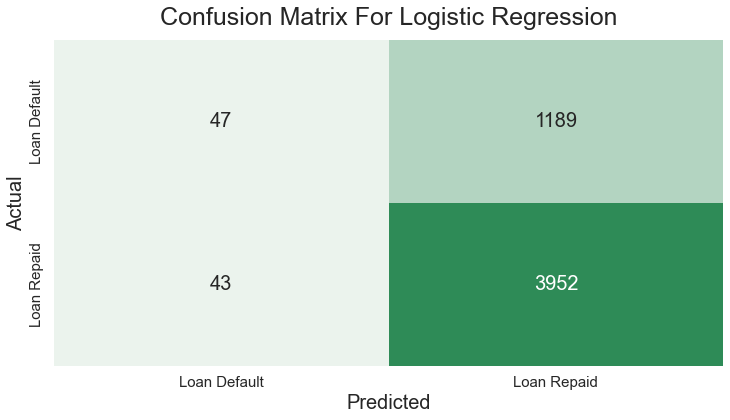

In [12]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [13]:
accuracy_score(y, y_pred)

0.7644809787803479

In [14]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

3952
1189
43
47
0.7644809787803479


In [15]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    3995
0.0    1236
Name: loan_status_bin, dtype: int64

0.7637163066335309


In [16]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 0.1% better than Null Model or "random investment"
TP / (TP+FP)

0.7687220385139077

In [17]:
#What if we "balance" the weight class to avoid "imbalanced" nature...No Change! 

In [18]:
lr_balanced = LogisticRegression(class_weight='balanced')

In [19]:
steps_balanced = [('model', lr_balanced)]
pipeline_balanced = Pipeline(steps=steps)

In [20]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline_balanced, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.77077364 0.76099426 0.76386233 0.76481836 0.76195029]
0.7644797755948434


In [21]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred_balanced = cross_val_predict(pipeline_balanced, X, y, cv=cv, n_jobs=-1)
conf_mat_balanced = confusion_matrix(y, y_pred_balanced)
conf_mat_balanced

array([[  47, 1189],
       [  43, 3952]])

In [22]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [23]:
y_pred_prob

array([[0.40953072, 0.59046928],
       [0.28916578, 0.71083422],
       [0.25118542, 0.74881458],
       ...,
       [0.25875671, 0.74124329],
       [0.26475039, 0.73524961],
       [0.36012228, 0.63987772]])

In [24]:
#Obtaining classification based on desired threshold of 0.8: 

y_pred_success = (y_pred_prob[:, 1] > 0.90).astype('float')
y_pred_success

array([0., 0., 0., ..., 0., 0., 0.])

In [25]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[1199,   37],
       [3676,  319]])

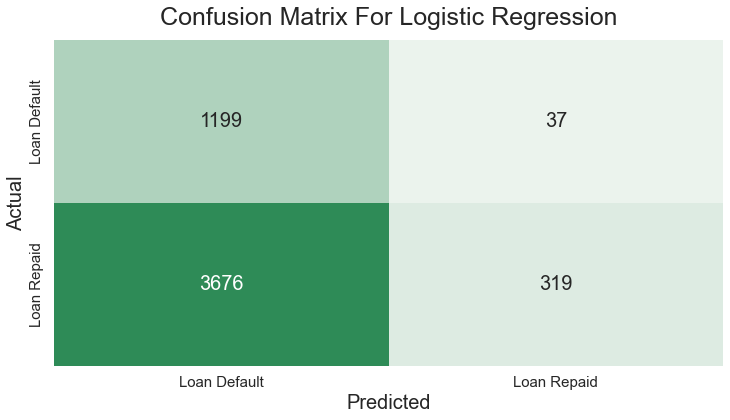

In [26]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [27]:
accuracy_score(y, y_pred_success)

0.2901930797170713

In [28]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

319
37
3676
1199
0.2901930797170713


In [29]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.8960674157303371

In [30]:
thresh = []
PosPredVal = []

for i in range(0,100,1):
    y_pred_success = (y_pred_prob[:, 1] > (i/100)).astype('float')
    conf_mat = confusion_matrix(y, y_pred_success)
    TN, FP, FN, TP = conf_mat.ravel()
    thresh.append(i)
    PosPredVal.append((TP/(TP+FP)))

print(np.max(PosPredVal))
print(PosPredVal.index(np.max(PosPredVal)))

0.8968253968253969
91


In [31]:
PosPredVal

[0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7637163066335309,
 0.7638623326959847,
 0.7638171734557276,
 0.7639632746748278,
 0.7641094317964415,
 0.7640191387559808,
 0.7641653905053599,
 0.7643116982577063,
 0.764266564534661,
 0.764266564534661,
 0.7644129477111664,
 0.76455938697318,
 0.7646607895745496,
 0.764908916586769,
 0.7653491941673062,
 0.7657899788827031,
 0.7656550134460238,
 0.7657120891793197,
 0.7663587374903772,
 0.76662169974947,
 0.7667374107659657,
 0.7669565217391304,

In [30]:
## Next question. what was characteristic of the 217 loans that defaulted??
## Get all loans which you predicted greater than 80% and find out which ones defaulted.
## Any pattern?????

In [31]:
#Do we drop all observations where the source is not verified? 
#Do we drop all observations loan amount is greater than half of one's income? 